In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import PIL 



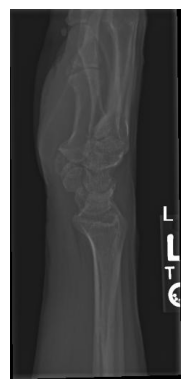

In [2]:
img = cv2.imread(r'val\fracture\image1_0_png.rf.d29cab92b154a83ca5bf7e40083673a2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define transforms (you can customize this)
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to a fixed size
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Path to your dataset folder
data_dir = "train/"

# Create dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Optional: Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True).to(device)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False).to(device)

# Get class names
class_names = dataset.classes
print("Classes:", class_names)


Classes: ['bruise', 'burn', 'cut', 'fracture']


In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 56 * 56, 512)  # Adjust input size based on your image size
        self.fc2 = nn.Linear(512, num_classes)
        self.sm  =nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sm(x)
        return x
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model, loss function, and optimizer
model = CNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    #calculate accuracy
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/20], Loss: 0.7915
Epoch [2/20], Loss: 0.7850
Epoch [3/20], Loss: 0.7873
Epoch [4/20], Loss: 0.7873
